### Youtube comments analysis 
#### Write a Spark program to analyze the text data.

In this notebook, we have a dataset of user comments for youtube videos related to animals or pets. We will attempt to identify cat or dog owners based on these comments, find out the topics important to them, and then identify video creators with the most viewers that are cat or dog owners.

The dataset provided for this coding test are comments for videos related to animals and/or pets. The dataset is 240MB compressed; please download the file using this google drive link:
https://drive.google.com/file/d/1o3DsS3jN_t2Mw3TsV0i7ySRmh9kyYi1a/view?usp=sharing

 The dataset file is comma separated, with a header line defining the field names, listed here:
● creator_name. Name of the YouTube channel creator.
● userid. Integer identifier for the users commenting on the YouTube channels.
● comment. Text of the comments made by the users.

Please use a recent version of PySpark (version 2.2 or higher) to analyze the data. Do not use
any external libraries; just use the native methods from pyspark.sql and pyspark.ml. (Do not
use pyspark.mllib as this has been deprecated.) Keep your code clean and efficient, with
enough documentation so that the grader can easily follow your train of thought. Summarize
the key results from each step. Explain how to execute your code from a command line
interface.

Step 1: Identify Cat And Dog Owners
Find the users who are cat and/or dog owners.

Step 2: Build And Evaluate Classifiers
Build classifiers for the cat and dog owners and measure the performance of the classifiers.

Step 3: Classify All The Users
Apply the cat/dog classifiers to all the users in the dataset. Estimate the fraction of all users
who are cat/dog owners.

Step 4: Extract Insights About Cat And Dog Owners
Find topics important to cat and dog owners.

Step 5: Identify Creators With Cat And Dog Owners In The Audience
Find creators with the most cat and/or dog owners. Find creators with the highest statistically
significant percentages of cat and/or dog owners.

#### 0. Data Exploration and Cleaning

In [4]:
df_clean=spark.read.csv("/FileStore/tables/animals_comments.csv",inferSchema=True,header=True)
df_clean.show(10)

+--------------------+------+-------------------------------------+
 creator_name|userid| comment|
+--------------------+------+-------------------------------------+
 Doug The Pug| 87.0| I shared this to ...|
 Doug The Pug| 87.0| Super cute 😀🐕🐶|
 bulletproof| 530.0| stop saying get e...|
 Meu Zoológico| 670.0| Tenho uma jiboia ...|
 ojatro|1031.0| I wanna see what ...|
 Tingle Triggers|1212.0| Well shit now Im ...|
Hope For Paws - O...|1806.0| when I saw the en...|
Hope For Paws - O...|2036.0| Holy crap. That i...|
 Life Story|2637.0|武器はクエストで貰えるんじゃないん...|
 Brian Barczyk|2698.0| Call the teddy Larry|
+--------------------+------+-------------------------------------+
only showing top 10 rows

In [5]:
df_clean.count() 

Out[ 2 ]: 5820035

In [6]:
df_clean = df_clean.na.drop(subset=["comment"])
df_clean.count()

Out[ 3 ]: 5818984

In [7]:
df_clean.show()

+--------------------+------+-------------------------------------+
 creator_name|userid| comment|
+--------------------+------+-------------------------------------+
 Doug The Pug| 87.0| I shared this to ...|
 Doug The Pug| 87.0| Super cute 😀🐕🐶|
 bulletproof| 530.0| stop saying get e...|
 Meu Zoológico| 670.0| Tenho uma jiboia ...|
 ojatro|1031.0| I wanna see what ...|
 Tingle Triggers|1212.0| Well shit now Im ...|
Hope For Paws - O...|1806.0| when I saw the en...|
Hope For Paws - O...|2036.0| Holy crap. That i...|
 Life Story|2637.0|武器はクエストで貰えるんじゃないん...|
 Brian Barczyk|2698.0| Call the teddy Larry|
 The Dodo|2702.0| 😐🤔😓😢😭😭😭😭😟|
Hope For Paws - O...|2911.0| That mother cat l...|
Hope For Paws - O...|2911.0| Its people like H...|
 Talking Kitty Cat|2911.0| steve: No wet foo...|
 Brave Wilderness|3224.0| Dont call this a ...|
 MaxluvsMya|3267.0| why are you alway...|
Rise Up Society F...|3372.0| Deb Tucker|
 The Dodo|3466.0| Thats a deer isnt...|
 Brave Wilderness|3466.0| there is no safe ...|
 Brave Wilderness|3466.0| Red before yellow...|
+--------------------+------+-------------------------------------+
only showing top 20 rows

In [8]:
# find user with preference of dog and cat
from pyspark.sql.functions import when
from pyspark.sql.functions import col

# you can user your ways to extract the label

df_clean = df_clean.withColumn("label", \
                           (when(col("comment").like("%my dog%"), 1) \
                           .when(col("comment").like("%I have a dog%"), 1) \
                           .when(col("comment").like("%my cat%"), 1) \
                           .when(col("comment").like("%I have a cat%"), 1) \
                           .when(col("comment").like("%my puppy%"), 1) \
                           .when(col("comment").like("%my pup%"), 1) \
                           .when(col("comment").like("%my kitty%"), 1) \
                           .when(col("comment").like("%my pussy%"), 1) \
                           .otherwise(0)))

In [9]:
df_clean.show()

+--------------------+------+-------------------------------------+-----+
 creator_name|userid| comment|label|
+--------------------+------+-------------------------------------+-----+
 Doug The Pug| 87.0| I shared this to ...| 0|
 Doug The Pug| 87.0| Super cute 😀🐕🐶| 0|
 bulletproof| 530.0| stop saying get e...| 0|
 Meu Zoológico| 670.0| Tenho uma jiboia ...| 0|
 ojatro|1031.0| I wanna see what ...| 0|
 Tingle Triggers|1212.0| Well shit now Im ...| 0|
Hope For Paws - O...|1806.0| when I saw the en...| 0|
Hope For Paws - O...|2036.0| Holy crap. That i...| 0|
 Life Story|2637.0|武器はクエストで貰えるんじゃないん...| 0|
 Brian Barczyk|2698.0| Call the teddy Larry| 0|
 The Dodo|2702.0| 😐🤔😓😢😭😭😭😭😟| 0|
Hope For Paws - O...|2911.0| That mother cat l...| 0|
Hope For Paws - O...|2911.0| Its people like H...| 0|
 Talking Kitty Cat|2911.0| steve: No wet foo...| 0|
 Brave Wilderness|3224.0| Dont call this a ...| 0|
 MaxluvsMya|3267.0| why are you alway...| 0|
Rise Up Society F...|3372.0| Deb Tucker| 0|
 The Dodo|3466.0| Thats a deer isnt...| 0|
 Brave Wilderness|3466.0| there is no safe ...| 0|
 Brave Wilderness|3466.0| Red before yellow...| 0|
+--------------------+------+-------------------------------------+-----+
only showing top 20 rows

#### 1. Data preprocessing and Build the classifier

In [11]:
from pyspark.ml.feature import RegexTokenizer, Word2Vec
from pyspark.ml.classification import LogisticRegression

# regular expression tokenizer
regexTokenizer = RegexTokenizer(inputCol="comment", outputCol="words", pattern="\\W")

word2Vec = Word2Vec(inputCol="words", outputCol="features")

In [12]:
from pyspark.ml import Pipeline
stages = [regexTokenizer, word2Vec]
partialPipeline = Pipeline().setStages(stages)

In [13]:
# Fit the pipeline to training documents.
pipelineModel = partialPipeline.fit(df_clean)
dataset = pipelineModel.transform(df_clean)

In [14]:
dataset.show()

+--------------------+------+-------------------------------------+-----+--------------------+--------------------+
 creator_name|userid| comment|label| words| features|
+--------------------+------+-------------------------------------+-----+--------------------+--------------------+
 Doug The Pug| 87.0| I shared this to ...| 0|[i, shared, this,...|[-0.1403650898825...|
 Doug The Pug| 87.0| Super cute 😀🐕🐶| 0| [super, cute]|[-0.1382095143198...|
 bulletproof| 530.0| stop saying get e...| 0|[stop, saying, ge...|[-0.0755950727140...|
 Meu Zoológico| 670.0| Tenho uma jiboia ...| 0|[tenho, uma, jibo...|[-0.3247505699594...|
 ojatro|1031.0| I wanna see what ...| 0|[i, wanna, see, w...|[-0.1321959465064...|
 Tingle Triggers|1212.0| Well shit now Im ...| 0|[well, shit, now,...|[-0.0587497293949...|
Hope For Paws - O...|1806.0| when I saw the en...| 0|[when, i, saw, th...|[-0.0769014868044...|
Hope For Paws - O...|2036.0| Holy crap. That i...| 0|[holy, crap, that...|[-0.2389420158444...|
 Life Story|2637.0|武器はクエストで貰えるんじゃないん...| 0| []| (100,[],[])|
 Brian Barczyk|2698.0| Call the teddy Larry| 0|[call, the, teddy...|[0.01075017265975...|
 The Dodo|2702.0| 😐🤔😓😢😭😭😭😭😟| 0| []| (100,[],[])|
Hope For Paws - O...|2911.0| That mother cat l...| 0|[that, mother, ca...|[-0.1643587352538...|
Hope For Paws - O...|2911.0| Its people like H...| 0|[its, people, lik...|[-0.1057769761110...|
 Talking Kitty Cat|2911.0| steve: No wet foo...| 0|[steve, no, wet, ...|[-0.0143818080382...|
 Brave Wilderness|3224.0| Dont call this a ...| 0|[dont, call, this...|[-0.0518531993563...|
 MaxluvsMya|3267.0| why are you alway...| 0|[why, are, you, a...|[-0.1849778325995...|
Rise Up Society F...|3372.0| Deb Tucker| 0| [deb, tucker]|[-0.0398699045181...|
 The Dodo|3466.0| Thats a deer isnt...| 0|[thats, a, deer, ...|[-0.0438031153753...|
 Brave Wilderness|3466.0| there is no safe ...| 0|[there, is, no, s...|[-0.1325143377625...|
 Brave Wilderness|3466.0| Red before yellow...| 0|[red, before, yel...|[-0.1101401605141...|
+--------------------+------+-------------------------------------+-----+--------------------+--------------------+
only showing top 20 rows

In [15]:
# Fit the model to dataset
lrModel = LogisticRegression().fit(dataset)

In [16]:
# ROC for training data
display(lrModel, dataset, "ROC")

org.apache.spark.SparkException: Job aborted due to stage failure: Task 6 in stage 163.0 failed 1 times, most recent failure: Lost task 6.0 in stage 163.0 (TID 802, localhost, executor driver): scala.MatchError: [[0.999732778490702,2.6722150929791444E-4],0] (of class org.apache.spark.sql.catalyst.expressions.GenericRowWithSchema)
	at com.databricks.backend.daemon.driver.ml.MLEntry$$anonfun$7.apply(MLEntry.scala:200)
	at com.databricks.backend.daemon.driver.ml.MLEntry$$anonfun$7.apply(MLEntry.scala:200)
	at scala.collection.Iterator$$anon$11.next(Iterator.scala:410)
	at org.apache.spark.storage.memory.MemoryStore.putIterator(MemoryStore.scala:222)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsValues(MemoryStore.scala:299)
	at org.apache.spark.storage.BlockManager$$anonfun$doPutIterator$1.apply(BlockManager.scala:1170)
	at org.apache.spark.storage.BlockManager$$anonfun$doPutIterator$1.apply(BlockManager.scala:1161)
	at org.apache.spark.storage.BlockManager.doPut(BlockManager.scala:1096)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1161)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:883)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:351)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:302)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:60)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:340)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:304)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.doRunTask(Task.scala:139)
	at org.apache.spark.scheduler.Task.run(Task.scala:112)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$13.apply(Executor.scala:497)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1481)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:503)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:2355)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:2343)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:2342)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2342)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:1096)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:1096)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1096)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2574)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2522)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2510)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:893)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2240)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2338)
	at org.apache.spark.rdd.RDD$$anonfun$reduce$1.apply(RDD.scala:1051)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:379)
	at org.apache.spark.rdd.RDD.reduce(RDD.scala:1033)
	at org.apache.spark.rdd.RDD$$anonfun$max$1.apply(

In [17]:
(lable0_train,lable0_test)=dataset.filter(col('label')==1).randomSplit([0.7, 0.3],seed = 100)
(lable1_train, lable1_ex)=dataset.filter(col('label')==0).randomSplit([0.005, 0.995],seed = 100)
(lable1_test, lable1_ex2)=lable1_ex.randomSplit([0.002, 0.998],seed = 100)

In [18]:
trainingData = lable0_train.union(lable1_train)
testData=lable0_test.union(lable1_test)

In [19]:
print("Dataset Count: " + str(dataset.count()))
print("Training Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))

Dataset Count: 5818984
Training Dataset Count: 56905
Test Dataset Count: 23339

### Fit and Evaluate Models
we are now ready to try some of the **Binary Classification** algorithms available in the Pipelines API.

##### LogisticRegression

In [22]:
from pyspark.ml.classification import LogisticRegression

# Create initial LogisticRegression model
lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10)

# Train model with Training Data
lrModel = lr.fit(trainingData)

In [23]:
import pandas as pd
import seaborn as sns
import pylab
import numpy as np

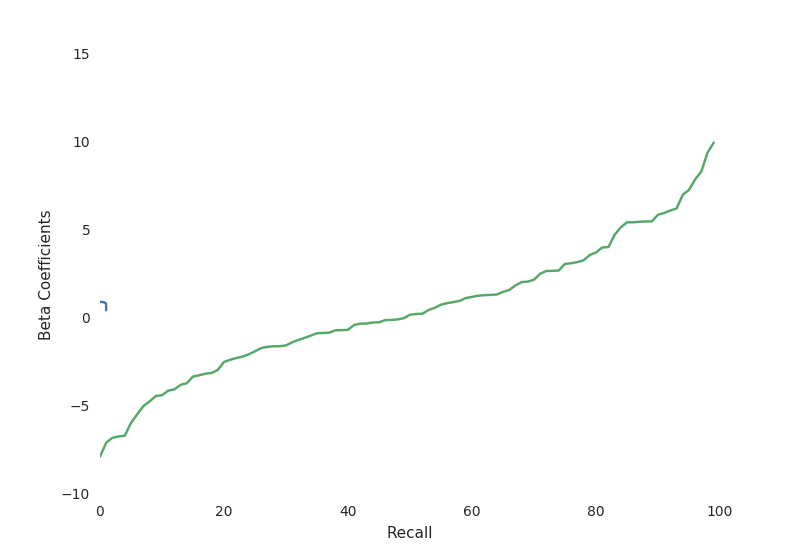

In [24]:
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
display()

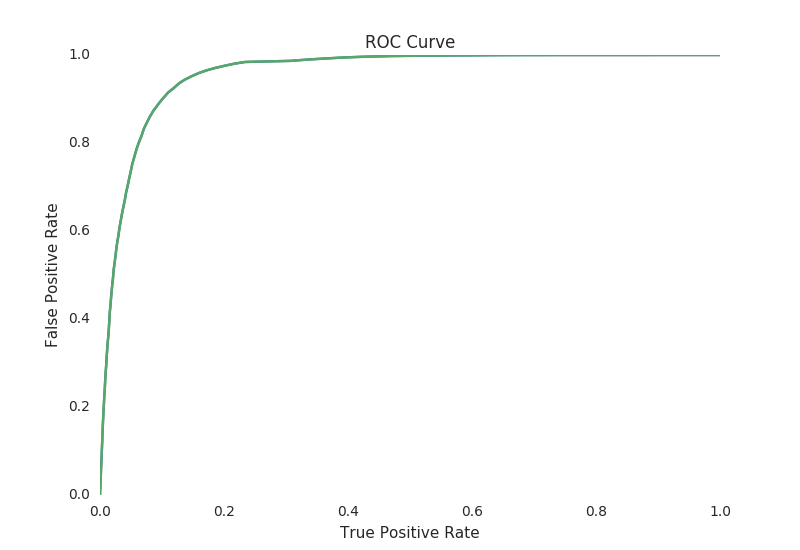

In [25]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
display()

In [26]:
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

Training set areaUnderROC: 0.9578961075608161

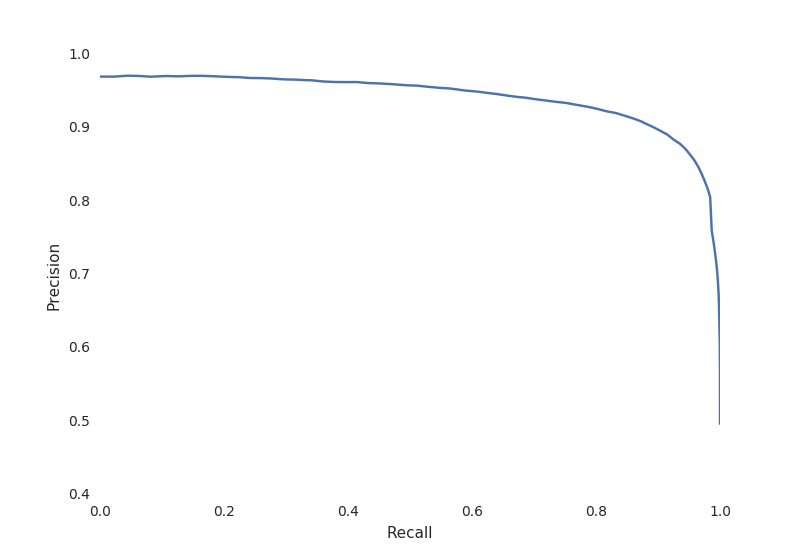

In [27]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
display()

In [28]:
# Make predictions on test data using the transform() method.
# LogisticRegression.transform() will only use the 'features' column.
predictions = lrModel.transform(testData)

In [29]:
# View model's predictions and probabilities of each prediction class
# You can select any columns in the above schema to view as well. For example's sake we will choose age & occupation
selected = predictions.select("label", "prediction", "probability", "creator_name", "userid", "comment")
display(selected)

label,prediction,probability,creator_name,userid,comment
1,1.0,"List(1, 2, List(), List(3.28804632814136E-4, 0.9996711953671858))",Aaron Rift,2212898.0,I need two of these Donald pet toys one of for my cat and one for my dog.
1,0.0,"List(1, 2, List(), List(0.5212544570358153, 0.4787455429641847))",Aarons Animals,426857.0,hey Aron I made a video with my cat! You inspired me !!! I am a big fan of you! Do you have any tips for me? thank you!
1,1.0,"List(1, 2, List(), List(0.029567997403990656, 0.9704320025960094))",Aarons Animals,785631.0,I love the show my cat from hell #mycatfromhell
1,1.0,"List(1, 2, List(), List(0.0012504860733455587, 0.9987495139266543))",Aarons Animals,881725.0,my cat died like if you agree
1,0.0,"List(1, 2, List(), List(0.6915298529119618, 0.3084701470880382))",Aarons Animals,1351699.0,lol haha! This is so well made! I showed my cat loving cousins this and they died of laughter later on there channel is gonna be “Babycat Vlogs” if you can sub to them it would be greatly appreciated. The channel isn’t yet made but that’s what it will be called.
1,1.0,"List(1, 2, List(), List(0.12963902103954528, 0.8703609789604547))",Aarons Animals,2002368.0,I did the same thing on my catI caught her sneaking out and buying drugs off a junkie in the alleyway then she smoked weed and also became the leader of the cat mafia
1,1.0,"List(1, 2, List(), List(0.20599332552020355, 0.7940066744797966))",Aarons Animals,2069967.0,Ur cat is savage when i even try to put on a shirt with my cat i will become pirate hook
1,1.0,"List(1, 2, List(), List(0.10849242508149504, 0.8915075749185051))",AfroHerpkeeper,932246.0,So a broad-headed skink got into my house and its hiding somewhere in my room I cant find it; any tips on how to lure it out of wherever its hiding? I dont want my dogs or cats to get it!
1,1.0,"List(1, 2, List(), List(0.3597814973842343, 0.6402185026157656))",Alex Knappenberger,194047.0,Lucy is so cute. she was looking at Bruce and Dexter to see if they were going to go. my dogs are like that too. lazy bums. hahaha
1,1.0,"List(1, 2, List(), List(0.2159916150135181, 0.784008384986482))",Alex Knappenberger,446192.0,Is it normal for my dog to stick her snout on the back edge of the water bowl and lick the water up using the side of the bowl?


We can use ``BinaryClassificationEvaluator`` to evaluate our model. We can set the required column names in ``rawPredictionCol`` and ``labelCol`` Param and the metric in ``metricName`` Param.

In [31]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Evaluate model
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
evaluator.evaluate(predictions)

Out[ 69 ]: 0.9563167219612031

The default metric for the ``BinaryClassificationEvaluator`` is ``areaUnderROC``

##### Parameter Tuning and K-fold cross-validation
Now we will try to tune the model paramers and the number of folds for cross-validation by ``ParamGridBuilder`` and the ``CrossValidator``.

In [34]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5, 2.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .addGrid(lr.maxIter, [1, 5, 10])
             .build())

In [35]:
# Create 5-fold CrossValidator
cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

# Run cross validations
cvModel = cv.fit(trainingData)
# this will likely take a fair amount of time because of the amount of models that we're creating and testing

In [36]:
# Use test set to measure the accuracy of our model on new data
predictions = cvModel.transform(testData)

In [37]:
# cvModel uses the best model found from the Cross Validation
# Evaluate best model
evaluator.evaluate(predictions)

Out[ 73 ]: 0.9559173998873842

### Decision Trees
The Decision Trees algorithm is popular because it handles categorical data and works out of the box with multiclass classification tasks.

In [39]:
from pyspark.ml.classification import DecisionTreeClassifier

# Create initial Decision Tree Model
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features", maxDepth=3)

# Train model with Training Data
dtModel = dt.fit(trainingData)

We can extract the number of nodes in our decision tress as well as the tree depth of our model.

In [41]:
print("numNodes = ", dtModel.numNodes)
print("depth = ", dtModel.depth)

numNodes = 7
depth = 3

In [42]:
display(dtModel)

treeNode
"{""index"":1,""featureType"":""continuous"",""prediction"":null,""threshold"":0.05638762912712991,""categories"":null,""feature"":96,""overflow"":false}"
"{""index"":0,""featureType"":null,""prediction"":0.0,""threshold"":null,""categories"":null,""feature"":null,""overflow"":false}"
"{""index"":3,""featureType"":""continuous"",""prediction"":null,""threshold"":0.014008500632674743,""categories"":null,""feature"":48,""overflow"":false}"
"{""index"":2,""featureType"":null,""prediction"":0.0,""threshold"":null,""categories"":null,""feature"":null,""overflow"":false}"
"{""index"":5,""featureType"":""continuous"",""prediction"":null,""threshold"":-0.07180589599496064,""categories"":null,""feature"":71,""overflow"":false}"
"{""index"":4,""featureType"":null,""prediction"":0.0,""threshold"":null,""categories"":null,""feature"":null,""overflow"":false}"
"{""index"":6,""featureType"":null,""prediction"":1.0,""threshold"":null,""categories"":null,""feature"":null,""overflow"":false}"


In [43]:
# Make predictions on test data using the Transformer.transform() method.
predictions = dtModel.transform(testData)

In [44]:
predictions.printSchema()

root
-- creator_name: string (nullable = true)
-- userid: double (nullable = true)
-- comment: string (nullable = true)
-- label: integer (nullable = false)
-- words: array (nullable = true)
 |-- element: string (containsNull = true)
-- features: vector (nullable = true)
-- rawPrediction: vector (nullable = true)
-- probability: vector (nullable = true)
-- prediction: double (nullable = false)

In [45]:
# View model's predictions and probabilities of each prediction class
selected = predictions.select("label", "prediction", "probability", "creator_name", "userid", "comment")
display(selected)

label,prediction,probability,creator_name,userid,comment
1,1.0,"List(1, 2, List(), List(0.16648189209164818, 0.8335181079083518))",Aaron Rift,2212898.0,I need two of these Donald pet toys one of for my cat and one for my dog.
1,0.0,"List(1, 2, List(), List(0.7976368328127122, 0.20236316718728778))",Aarons Animals,426857.0,hey Aron I made a video with my cat! You inspired me !!! I am a big fan of you! Do you have any tips for me? thank you!
1,1.0,"List(1, 2, List(), List(0.16648189209164818, 0.8335181079083518))",Aarons Animals,785631.0,I love the show my cat from hell #mycatfromhell
1,1.0,"List(1, 2, List(), List(0.16648189209164818, 0.8335181079083518))",Aarons Animals,881725.0,my cat died like if you agree
1,0.0,"List(1, 2, List(), List(0.866607528968232, 0.13339247103176805))",Aarons Animals,1351699.0,lol haha! This is so well made! I showed my cat loving cousins this and they died of laughter later on there channel is gonna be “Babycat Vlogs” if you can sub to them it would be greatly appreciated. The channel isn’t yet made but that’s what it will be called.
1,1.0,"List(1, 2, List(), List(0.16648189209164818, 0.8335181079083518))",Aarons Animals,2002368.0,I did the same thing on my catI caught her sneaking out and buying drugs off a junkie in the alleyway then she smoked weed and also became the leader of the cat mafia
1,1.0,"List(1, 2, List(), List(0.16648189209164818, 0.8335181079083518))",Aarons Animals,2069967.0,Ur cat is savage when i even try to put on a shirt with my cat i will become pirate hook
1,0.0,"List(1, 2, List(), List(0.7976368328127122, 0.20236316718728778))",AfroHerpkeeper,932246.0,So a broad-headed skink got into my house and its hiding somewhere in my room I cant find it; any tips on how to lure it out of wherever its hiding? I dont want my dogs or cats to get it!
1,1.0,"List(1, 2, List(), List(0.16648189209164818, 0.8335181079083518))",Alex Knappenberger,194047.0,Lucy is so cute. she was looking at Bruce and Dexter to see if they were going to go. my dogs are like that too. lazy bums. hahaha
1,1.0,"List(1, 2, List(), List(0.16648189209164818, 0.8335181079083518))",Alex Knappenberger,446192.0,Is it normal for my dog to stick her snout on the back edge of the water bowl and lick the water up using the side of the bowl?


We will evaluate our Decision Tree model with ``BinaryClassificationEvaluator``.

In [47]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
# Evaluate model
evaluator = BinaryClassificationEvaluator()
evaluator.evaluate(predictions)

Out[ 80 ]: 0.8025263039364545

Entropy and the Gini coefficient are the supported measures of impurity for Decision Trees. This is ``Gini`` by default. Changing this value is simple, ``model.setImpurity("Entropy")``.

In [49]:
dt.getImpurity()

Out[ 81 ]: 'gini'

Now we will try tuning the model with the ``ParamGridBuilder`` and the ``CrossValidator``.

As we indicate 3 values for maxDepth and 3 values for maxBin, this grid will have 3 x 3 = 9 parameter settings for ``CrossValidator`` to choose from. We will create a 5-fold CrossValidator.

In [51]:
# Create ParamGrid for Cross Validation
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
paramGrid = (ParamGridBuilder()
             .addGrid(dt.maxDepth, [1, 2, 6, 10])
             .addGrid(dt.maxBins, [20, 40, 80])
             .build())

In [52]:
# Create 5-fold CrossValidator
cv = CrossValidator(estimator=dt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

# Run cross validations
cvModel = cv.fit(trainingData)
# Takes ~5 minutes

In [53]:
print("numNodes = ", cvModel.bestModel.numNodes)
print("depth = ", cvModel.bestModel.depth)

numNodes = 1155
depth = 10

In [54]:
# Use test set to measure the accuracy of our model on new data
predictions = cvModel.transform(testData)

In [55]:
# cvModel uses the best model found from the Cross Validation
# Evaluate best model
evaluator.evaluate(predictions)

Out[ 86 ]: 0.9195154384232358

In [56]:
# View Best model's predictions and probabilities of each prediction class
selected = predictions.select("label", "prediction", "probability", "creator_name", "userid", "comment")
display(selected)

label,prediction,probability,creator_name,userid,comment
1,1.0,"List(1, 2, List(), List(0.09635213586344338, 0.9036478641365566))",Aaron Rift,2212898.0,I need two of these Donald pet toys one of for my cat and one for my dog.
1,0.0,"List(1, 2, List(), List(0.7892561983471075, 0.21074380165289255))",Aarons Animals,426857.0,hey Aron I made a video with my cat! You inspired me !!! I am a big fan of you! Do you have any tips for me? thank you!
1,1.0,"List(1, 2, List(), List(0.09635213586344338, 0.9036478641365566))",Aarons Animals,785631.0,I love the show my cat from hell #mycatfromhell
1,1.0,"List(1, 2, List(), List(0.09635213586344338, 0.9036478641365566))",Aarons Animals,881725.0,my cat died like if you agree
1,0.0,"List(1, 2, List(), List(0.5116279069767442, 0.4883720930232558))",Aarons Animals,1351699.0,lol haha! This is so well made! I showed my cat loving cousins this and they died of laughter later on there channel is gonna be “Babycat Vlogs” if you can sub to them it would be greatly appreciated. The channel isn’t yet made but that’s what it will be called.
1,1.0,"List(1, 2, List(), List(0.09635213586344338, 0.9036478641365566))",Aarons Animals,2002368.0,I did the same thing on my catI caught her sneaking out and buying drugs off a junkie in the alleyway then she smoked weed and also became the leader of the cat mafia
1,1.0,"List(1, 2, List(), List(0.09635213586344338, 0.9036478641365566))",Aarons Animals,2069967.0,Ur cat is savage when i even try to put on a shirt with my cat i will become pirate hook
1,1.0,"List(1, 2, List(), List(0.14285714285714285, 0.8571428571428571))",AfroHerpkeeper,932246.0,So a broad-headed skink got into my house and its hiding somewhere in my room I cant find it; any tips on how to lure it out of wherever its hiding? I dont want my dogs or cats to get it!
1,1.0,"List(1, 2, List(), List(0.09635213586344338, 0.9036478641365566))",Alex Knappenberger,194047.0,Lucy is so cute. she was looking at Bruce and Dexter to see if they were going to go. my dogs are like that too. lazy bums. hahaha
1,1.0,"List(1, 2, List(), List(0.23159784560143626, 0.7684021543985637))",Alex Knappenberger,446192.0,Is it normal for my dog to stick her snout on the back edge of the water bowl and lick the water up using the side of the bowl?


### RandomForest

In [58]:
from pyspark.ml.classification import RandomForestClassifier

# Create an initial RandomForest model.
rf = RandomForestClassifier(labelCol="label", featuresCol="features")

# Train model with Training Data
rfModel = rf.fit(trainingData)

In [59]:
# Make predictions on test data using the Transformer.transform() method.
predictions = rfModel.transform(testData)

In [60]:
predictions.printSchema()

root
-- creator_name: string (nullable = true)
-- userid: double (nullable = true)
-- comment: string (nullable = true)
-- label: integer (nullable = false)
-- words: array (nullable = true)
 |-- element: string (containsNull = true)
-- features: vector (nullable = true)
-- rawPrediction: vector (nullable = true)
-- probability: vector (nullable = true)
-- prediction: double (nullable = false)

In [61]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Evaluate model
evaluator = BinaryClassificationEvaluator()
evaluator.evaluate(predictions)

Out[ 91 ]: 0.9466620767037265

Now we will try tuning the model with the ``ParamGridBuilder`` and the ``CrossValidator``.

As we indicate 3 values for maxDepth, 2 values for maxBin, and 2 values for numTrees,
this grid will have 3 x 2 x 2 = 12 parameter settings for ``CrossValidator`` to choose from.
We will create a 5-fold ``CrossValidator``.

In [63]:
# Create ParamGrid for Cross Validation
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (ParamGridBuilder()
             .addGrid(rf.maxDepth, [2, 4, 6])
             .addGrid(rf.maxBins, [20, 60])
             .addGrid(rf.numTrees, [5, 20])
             .build())

In [64]:
# Create 5-fold CrossValidator
cv = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

# Run cross validations.  This can take about 6 minutes since it is training over 20 trees!
cvModel = cv.fit(trainingData)

In [65]:
# Use test set here so we can measure the accuracy of our model on new data
predictions = cvModel.transform(testData)

In [66]:
# cvModel uses the best model found from the Cross Validation
# Evaluate best model
evaluator.evaluate(predictions)

Out[ 95 ]: 0.9521390122207568

In [67]:
# View Best model's predictions and probabilities of each prediction class
selected = predictions.select("label", "prediction", "probability", "creator_name", "userid", "comment")
display(selected)

label,prediction,probability,creator_name,userid,comment
1,1.0,"List(1, 2, List(), List(0.20719873135803102, 0.792801268641969))",Aaron Rift,2212898.0,I need two of these Donald pet toys one of for my cat and one for my dog.
1,0.0,"List(1, 2, List(), List(0.5308066917651644, 0.4691933082348356))",Aarons Animals,426857.0,hey Aron I made a video with my cat! You inspired me !!! I am a big fan of you! Do you have any tips for me? thank you!
1,1.0,"List(1, 2, List(), List(0.36803136572895834, 0.6319686342710418))",Aarons Animals,785631.0,I love the show my cat from hell #mycatfromhell
1,1.0,"List(1, 2, List(), List(0.2718265757123598, 0.7281734242876402))",Aarons Animals,881725.0,my cat died like if you agree
1,0.0,"List(1, 2, List(), List(0.6055594588039912, 0.3944405411960088))",Aarons Animals,1351699.0,lol haha! This is so well made! I showed my cat loving cousins this and they died of laughter later on there channel is gonna be “Babycat Vlogs” if you can sub to them it would be greatly appreciated. The channel isn’t yet made but that’s what it will be called.
1,1.0,"List(1, 2, List(), List(0.3331825088438516, 0.6668174911561484))",Aarons Animals,2002368.0,I did the same thing on my catI caught her sneaking out and buying drugs off a junkie in the alleyway then she smoked weed and also became the leader of the cat mafia
1,1.0,"List(1, 2, List(), List(0.3281826011331107, 0.6718173988668893))",Aarons Animals,2069967.0,Ur cat is savage when i even try to put on a shirt with my cat i will become pirate hook
1,1.0,"List(1, 2, List(), List(0.3371188303545809, 0.6628811696454191))",AfroHerpkeeper,932246.0,So a broad-headed skink got into my house and its hiding somewhere in my room I cant find it; any tips on how to lure it out of wherever its hiding? I dont want my dogs or cats to get it!
1,1.0,"List(1, 2, List(), List(0.20859313584136796, 0.7914068641586322))",Alex Knappenberger,194047.0,Lucy is so cute. she was looking at Bruce and Dexter to see if they were going to go. my dogs are like that too. lazy bums. hahaha
1,1.0,"List(1, 2, List(), List(0.3323516048488224, 0.6676483951511776))",Alex Knappenberger,446192.0,Is it normal for my dog to stick her snout on the back edge of the water bowl and lick the water up using the side of the bowl?


##### Gradient boosting

In [69]:
from pyspark.ml.classification import GBTClassifier

# Create an initial RandomForest model.
gbt = GBTClassifier(labelCol="label", featuresCol="features", maxIter=10)

# Train model with Training Data
gbtModel = gbt.fit(trainingData)

In [70]:
# Make predictions on test data using the Transformer.transform() method.
predictions = gbtModel.transform(testData)

In [71]:
predictions.printSchema()

root
-- creator_name: string (nullable = true)
-- userid: double (nullable = true)
-- comment: string (nullable = true)
-- label: integer (nullable = false)
-- words: array (nullable = true)
 |-- element: string (containsNull = true)
-- features: vector (nullable = true)
-- rawPrediction: vector (nullable = true)
-- probability: vector (nullable = true)
-- prediction: double (nullable = false)

In [72]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Evaluate model
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.9516843140573283

In [73]:
# Create ParamGrid for Cross Validation
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 60])
             .addGrid(gbt.maxIter, [10, 20])
             .build())

In [74]:
cv = CrossValidator(estimator = gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

# Run cross validations. This can take about 6 minutes since it is training over 20 trees.
cvModel = cv.fit(trainingData)
predictions = cvModel.transform(testData)
evaluator.evaluate(predictions)

Out[ 102 ]: 0.9652447700306774

#### 2. Classify All The Users

In [76]:
cond = (df_clean.comment.rlike("(^our|Our|My|my) (a|\d+|..|...|....) (cat|cats|kitten|kittens|dog|dogs|puppy|puppies)") |
        df_clean.comment.rlike("(^our|Our|My|my) (cat|cats|kitten|kittens|dog|dogs|puppy|puppies)") |
        df_clean.comment.rlike("(I|We) have (a|\d+|..|...|....) (cat|cats|kitten|kittens|dog|dogs|puppy|puppies)") |
        df_clean.comment.rlike("(I|We) have (cat|cats|kitten|kittens|dog|dogs|puppy|puppies)"))
df_new = df_clean.withColumn('dog_cat',  cond)

In [77]:
num_count = df_new.groupBy('dog_cat').count().collect()
display(num_count)

dog_cat,count
true,58218
false,5760766


In [78]:
print("Number of people who own dog or cat: ", num_count[0][1])
print("Ratio of target label / total", str(num_count[0][1] / df_new.count() * 100), "% => data is imbalanced, need downsampling later")

Number of people who own dog or cat: 58218
Ratio of target label / total 1.0004839332776994 % => data is imbalanced, need downsampling later

In [79]:
df_new = df_new.select("creator_name", 'userid', 'comment', 'label', df_new["dog_cat"].cast("int"))
display(df_new)

creator_name,userid,comment,label,dog_cat
Doug The Pug,87.0,I shared this to my friends and mom the were lol,0,0
Doug The Pug,87.0,Super cute 😀🐕🐶,0,0
bulletproof,530.0,stop saying get em youre literally dumb . have some common sense or dont own this kind of dog. fucking retarded I swear,0,0
Meu Zoológico,670.0,Tenho uma jiboia e um largato,0,0
ojatro,1031.0,I wanna see what happened to the pigs after that please,0,0
Tingle Triggers,1212.0,Well shit now Im hungry,0,0
Hope For Paws - Official Rescue Channel,1806.0,when I saw the end it said to adopt I saw different animal sites I was mad that they separated the cute little pups after being together for a long time,0,0
Hope For Paws - Official Rescue Channel,2036.0,Holy crap. That is quite literally the most adorable pup Ive ever seen.,0,0
Life Story,2637.0,武器はクエストで貰えるんじゃないんですか？,0,0
Brian Barczyk,2698.0,Call the teddy Larry,0,0


In [80]:
# Comment contain "cat" or "dog"
cond_cat_dog = (df_new["comment"].like("%dog%") | df_new["comment"].like("%cat%"))
df_new1 = df_new.select("creator_name", "userid", "comment", "dog_cat").withColumn("dog_cat_all", cond_cat_dog)
df_new1 = df_new1.select("creator_name", "userid", "comment", "dog_cat", df_new1["dog_cat_all"].cast("int"))

In [81]:
from pyspark.sql import functions as f

# collect all comments left per userId
df_new2 = df_new1.select("creator_name", "userid", "comment", "dog_cat", "dog_cat_all").groupBy("userid").\
agg(f.concat_ws(" ", f.collect_list(df_new1["comment"])).alias("comment_new"))

df_clean_cat = df_new1.select("creator_name", "userid", "comment", "dog_cat", "dog_cat_all").groupBy("userid").agg({"dog_cat":"max", "dog_cat_all":"max"})

In [82]:
df_new3 = df_new2.join(df_clean_cat, "userid", "outer")
df_new3 = df_new3.withColumnRenamed("max(dog_cat)", "dog_cat")
df_new3 = df_new3.withColumnRenamed("max(dog_cat_all)", "dog_cat_all")

In [83]:
from statsmodels.stats.proportion import proportions_ztest

# count the number of comments that contain dog or cat keywords
dog_cat_keyword = df_new.select("dog_cat_all").groupBy("dog_cat_all").count().toPandas()

# count the number of comments that are dog owners or cat owners
dog_cat_owner_keyword = df_new.select("dog_cat").groupBy("dog_cat").count().toPandas()

# count total number of the data
total_df_num = df_new.count()
count = np.array([dog_cat_owner_keyword["count"][0], dog_cat_keyword["count"][0]])
nobs = np.array([dog_cat_keyword["count"][0], total_df_num])
stat, pval = proportions_ztest(count, nobs, 0.05)

# compare them
print("percent of people who talk about dogs or cats", 
      str(round(float(dog_cat_keyword["count"][0]) / total_df_num * 100, 2)), "%")

print("percent of people who have dogs or cats", 
      str(round(float(dog_cat_owner_keyword["count"][0]) / total_df_num * 100, 2)), "%")

print("percent of people who talk about dogs or cats that have them", 
      str(round(float(dog_cat_owner_keyword["count"][0]) / dog_cat_keyword["count"][0] * 100, 2)), "%")

print("proportion z test:", "{0:0.3f}".format(pval))
print("---------------------------------------------------------------------")
print("people who mention dog or cat keywords are more likely to have them")

percent of people who talk about dogs or cats 11.64 %
percent of people who have dogs or cats 1.94 %
percent of people who talk about dogs or cats that have them 16.69 %
proportion z test: 0.458
---------------------------------------------------------------------
people who mention dog or cat keywords are more likely to have them

#### 3. Get insigts of Users

In [85]:
result2 = df_new[df_new["dog_cat"] == 1.0]
num_creator = result2.select("creator_name").distinct().count()
num_userid = result2.select("userid").distinct().count()
avg_num_comments = num_userid / num_creator * 1.0
print(avg_num_comments)

67.15258855585832

In [86]:
creater_visitors = df_new.groupBy("creator_name").agg({"userid": "count"}).orderBy("count(userid)", ascending = False).toPandas()
creater_visitors_top_15 = creater_visitors["count(userid)"][:15]
creater_visitors_top_15 = creater_visitors_top_15.values

creater_visitors2 = result2.groupBy("creator_name").agg({"userid": "count"}).orderBy("count(userid)", ascending = False).toPandas()
creater_visitors2_top_15 = creater_visitors2["count(userid)"][:15]
creater_visitors2_top_15 = creater_visitors2_top_15.values

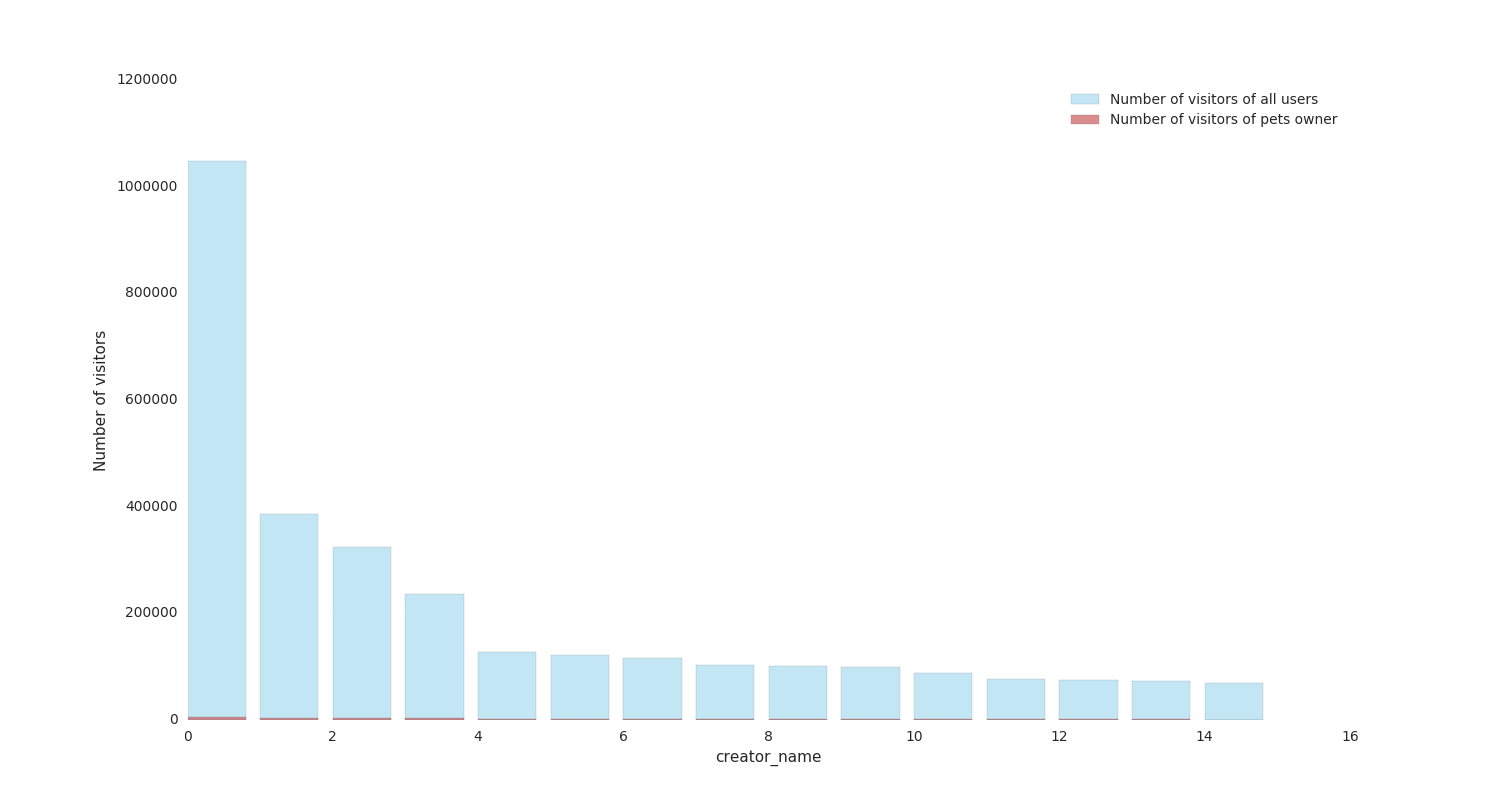

In [87]:
fig = plt.figure(figsize=(15,8))
ax = plt.subplot(111)
ax.grid(True)
ax.bar(np.arange(15), creater_visitors_top_15, alpha = 0.5, edgecolor = "grey", color = "SkyBlue")
ax.bar(np.arange(15), creater_visitors2_top_15, alpha = 0.7, edgecolor = "grey", color = "IndianRed")
ax.set_xlabel("creator_name")
ax.set_ylabel("Number of visitors")
ax.legend(["Number of visitors of all users", "Number of visitors of pets owner"])
display(fig)

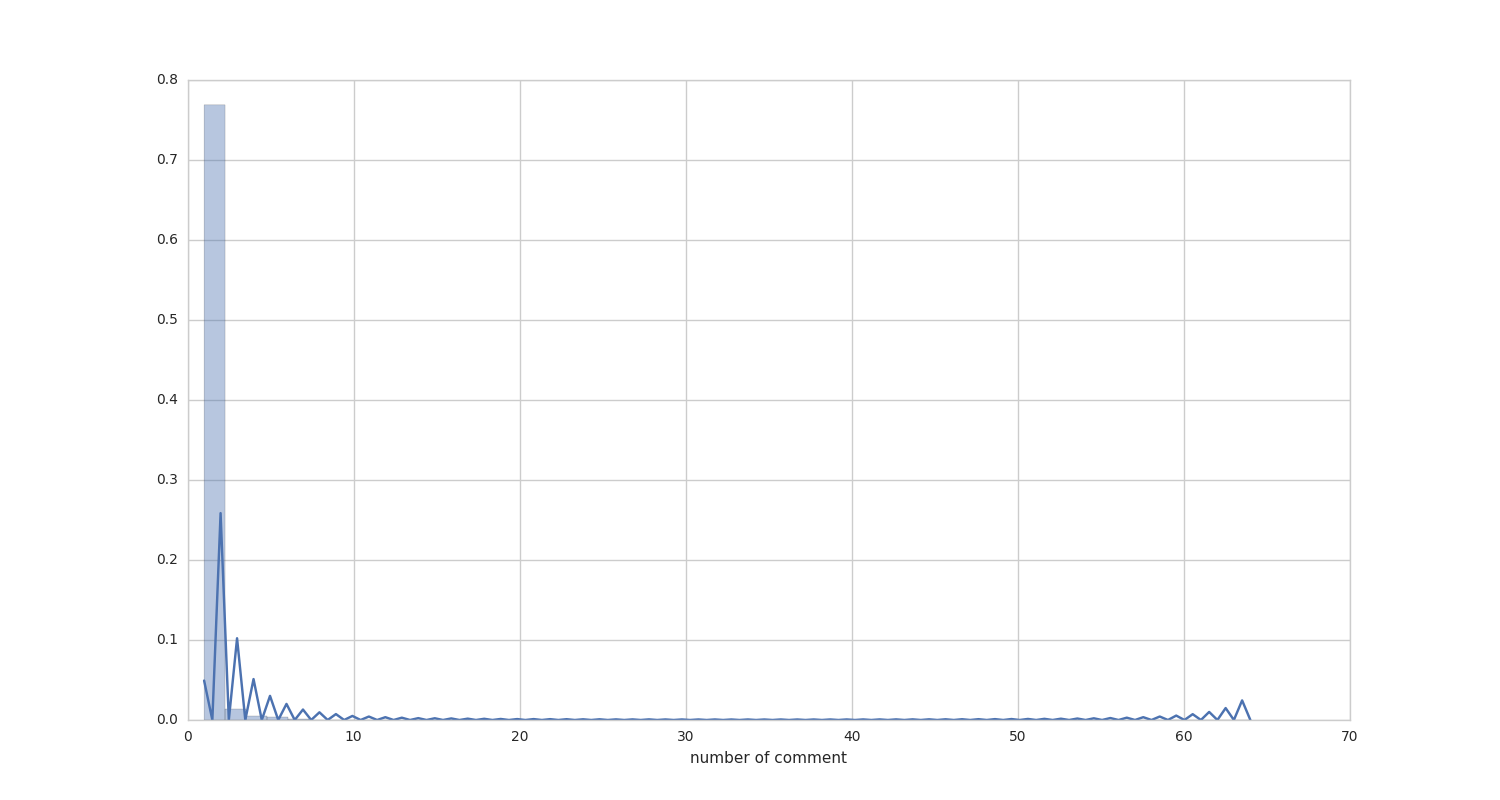

In [88]:
sns.set(color_codes=True,  style = "whitegrid")
fig = plt.figure(figsize=(15,8))
comments_from_owner = result2.groupBy("userid").agg({"comment": "count"}).orderBy("count(comment)", ascending = False).toPandas()
sns.distplot(comments_from_owner["count(comment)"])
plt.xlabel("number of comment")
display(fig)

print(comments_from_owner)

#### 4. Identify Creators With Cat And Dog Owners In The Audience

In [90]:
df_dog_cat = df_new[df_new["dog_cat"] == 1]
display(df_dog_cat)

creator_name,userid,comment,label,dog_cat
The Dodo,24401.0,Now I want to try that with my dog!!!,1,1
Cole & Marmalade,43112.0,I blow smoke in my cats ear right to his brain,1,1
Zak Georges Dog Training rEvolution,63541.0,my dog lucky wont eat of his bowl hell only eat out peoples hands how do i get him to eat out of his bowl,1,1
Zak Georges Dog Training rEvolution,107095.0,My dog is a Chihuahua mixed with a weiner dog hes so 💝cute💝,0,1
Brian Barczyk,123777.0,My dog past away at 13 and she was a really awesome but she past the vet said she might have belly cancer and she kept puking I love you so much I want to support you in anyway I hope you comment back😚😚😚😚😚😏😚😚😚😢😢😢😭😭😭😭😭😢😢😢😢,0,1
DarkDynastyK9s,175184.0,thats what my dog do,1,1
meow meow,183040.0,My cat is pregnant and has 5 baby kittens inside,0,1
meow meow,183040.0,My cat is pregnant,0,1
Robin Seplut,198679.0,There so cute I just want one but I have cats 🐈 under my dads room,0,1
The Pet Collective,203881.0,Im so happy i think Im almost crying Im hugging my dog Ik its not a cat but its a animal that need love,1,1


In [91]:
df_dog_cat = df_dog_cat.withColumn("dog", \
                           (when(col("comment").like("%my dog%"), 1) \
                           .when(col("comment").like("%I have a dog%"), 1) \
                           .when(col("comment").like("%my puppy%"), 1) \
                           .when(col("comment").like("%my pup%"), 1) \
                           .otherwise(0)))
df_dog_cat = df_dog_cat.withColumn("cat", \
                           (when(col("comment").like("%my cat%"), 1) \
                           .when(col("comment").like("%I have a cat%"), 1) \
                           .when(col("comment").like("%my kitty%"), 1) \
                           .when(col("comment").like("%my pussy%"), 1) \
                           .otherwise(0)))
display(df_dog_cat)

creator_name,userid,comment,label,dog_cat,dog,cat
The Dodo,24401.0,Now I want to try that with my dog!!!,1,1,1,0
Cole & Marmalade,43112.0,I blow smoke in my cats ear right to his brain,1,1,0,1
Zak Georges Dog Training rEvolution,63541.0,my dog lucky wont eat of his bowl hell only eat out peoples hands how do i get him to eat out of his bowl,1,1,1,0
Zak Georges Dog Training rEvolution,107095.0,My dog is a Chihuahua mixed with a weiner dog hes so 💝cute💝,0,1,0,0
Brian Barczyk,123777.0,My dog past away at 13 and she was a really awesome but she past the vet said she might have belly cancer and she kept puking I love you so much I want to support you in anyway I hope you comment back😚😚😚😚😚😏😚😚😚😢😢😢😭😭😭😭😭😢😢😢😢,0,1,0,0
DarkDynastyK9s,175184.0,thats what my dog do,1,1,1,0
meow meow,183040.0,My cat is pregnant and has 5 baby kittens inside,0,1,0,0
meow meow,183040.0,My cat is pregnant,0,1,0,0
Robin Seplut,198679.0,There so cute I just want one but I have cats 🐈 under my dads room,0,1,0,0
The Pet Collective,203881.0,Im so happy i think Im almost crying Im hugging my dog Ik its not a cat but its a animal that need love,1,1,1,0


In [92]:
training, testing = df_new.randomSplit([0.8, 0.2])
count_for_down_sample = df_new.groupBy("dog_cat").count().collect()
# down sample to 1:1(dog_cat == 0:dog_cat == 1)
df_clean = df_clean.withColumn("label", \
                           (when(col("comment").like("%my dog%"), 1) \
                           .when(col("comment").like("%I have a dog%"), 1) \
                           .when(col("comment").like("%my cat%"), 1) \
                           .when(col("comment").like("%I have a cat%"), 1) \
                           .when(col("comment").like("%my puppy%"), 1) \
                           .when(col("comment").like("%my pup%"), 1) \
                           .when(col("comment").like("%my kitty%"), 1) \
                           .when(col("comment").like("%my pussy%"), 1) \
                           .otherwise(0)))

In [93]:
# LogisticRegression
lr = LogisticRegression(featuresCol = "features", labelCol = "dog_cat")

# RandomForestClassifier
rf = RandomForestClassifier(featuresCol = "features", labelCol = "dog_cat")

# GBTClassifier
gbt = GBTClassifier(featuresCol = "features", labelCol = "dog_cat")

# list for training model
model_names = ["LogisticRegression", "RandomForestClassifier", "GBTClassifier"]
model_ls = [lr, rf, gbt]
best_AUC = 0

# train and output AUC score of test set
for i, classifier in enumerate(model_ls):
  Model = classifier.fit(training2)
  r = Model.transform(testing)
  eval = BinaryClassificationEvaluator(rawPredictionCol = "prediction", labelCol = "dog_cat")
  AUC = eval.evaluate(r)
  print("AUC score of", model_names[i], ":", AUC)
  if AUC > best_AUC:
    best_AUC = AUC
    best_model = model_names[i]
# print bext model name
print("Best model without tuning is:", best_model)

--------------------------------------------------------------------------- 
 IllegalArgumentException Traceback (most recent call last)
 <command-3772259093462495> in <module> () 
 15 # train and output AUC score of test set 
 16 for i , classifier in enumerate ( model_ls ) : 
 ---> 17 Model = classifier . fit ( training2 ) 
 18 r = Model . transform ( testing ) 
 19 eval = BinaryClassificationEvaluator ( rawPredictionCol = "prediction" , labelCol = "dog_cat" ) 

 /databricks/spark/python/pyspark/ml/base.py in fit (self, dataset, params) 
 130 return self . copy ( params ) . _fit ( dataset ) 
 131 else : 
 --> 132 return self . _fit ( dataset ) 
 133 else : 
 134 raise ValueError("Params must be either a param map or a list/tuple of param maps, "

 /databricks/spark/python/pyspark/ml/wrapper.py in _fit (self, dataset) 
 293 
 294 def _fit ( self , dataset ) : 
 --> 295 java_model = self . _fit_java ( dataset ) 
 296 model = self . _create_model ( java_model ) 
 297 return self . _copyValues ( model ) 

 /databricks/spark/python/pyspark/ml/wrapper.py in _fit_java (self, dataset) 
 290 """
 291 self . _transfer_params_to_java ( ) 
 --> 292 return self . _java_obj . fit ( dataset . _jdf ) 
 293 
 294 def _fit ( self , dataset ) : 

 /databricks/spark/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py in __call__ (self, *args) 
 1255 answer = self . gateway_client . send_command ( command ) 
 1256 return_value = get_return_value(
 -> 1257 answer, self.gateway_client, self.target_id, self.name)
 1258 
 1259 for temp_arg in temp_args : 

 /databricks/spark/python/pyspark/sql/utils.py in deco (*a, **kw) 
 77 raise QueryExecutionException ( s . split ( ': ' , 1 ) [ 1 ] , stackTrace ) 
 78 if s . startswith ( 'java.lang.IllegalArgumentException: ' ) : 
 ---> 79 raise IllegalArgumentException ( s . split ( ': ' , 1 ) [ 1 ] , stackTrace ) 
 80 raise 
 81 return deco 

 IllegalArgumentException : 'Field "features" does not exist.\nAvailable fields: creator_name, userid, comment, label, dog_cat'

To sum up, we have learned how to build a binary classification application using PySpark and MLlib Pipelines API. We tried four algprithms and gradient boosting performed best on our data set.